# GE 461 Introduction to Data Science 2024

# Project 4 – Fall Detection

### Görkem Kadir Solun 22003214

### Notes

Changing the random seeds affects the output.

You may need to update the data path.

Finding the best MLP may take up to 7 minutes.

It may give warnings about the convergence of the MLP model.

### Imports


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import random

# Set random seed
random_state = 92
random.seed(random_state)
np.random.seed(random_state)

# make pandas do not truncate
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

### Load Data


In [15]:
# Load the data
# NOTE: This data may need to be configured to the correct path
directory = os.getcwd()
data_path = os.path.join(directory, "data\\falldetection_dataset.csv")

# Read the data with the first row as the data instead of the header
raw_data = pd.read_csv(data_path, header=None)

# Get the labels at the second column
data_labels = raw_data.iloc[:, 1]
data_unique_labels = data_labels.unique()
# Get the rest of the data by removing the first two columns
data_features = raw_data.drop(raw_data.columns[[0, 1]], axis=1)

print("Data shape: ", data_features.shape)
print("Labels shape: ", data_labels.shape)
print("Unique labels: ", data_unique_labels)

""" print("Data: ", data)
print("Labels: ", labels) """

Data shape:  (566, 306)
Labels shape:  (566,)
Unique labels:  ['F' 'NF']


' print("Data: ", data)\nprint("Labels: ", labels) '

## Part A

### PCA

Applied PCA to the data to reduce the dimensionality of the data to 2.


Principal Components shape:  (566, 2)
Explained Variance Ratios:  [0.75307248 0.0851159 ]
Eigenvalues:  [31464.17423647  3556.2334265 ]
Total Explained Variance Percentage:  83.81883815238406


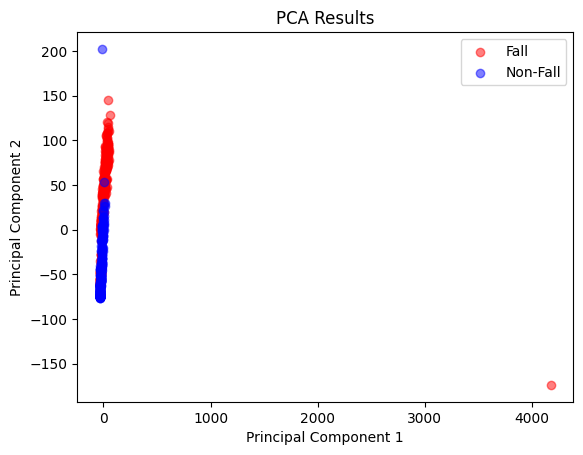

In [16]:
# Apply PCA to the data to reduce the dimensionality of the data to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_features)
explained_variance_ratios = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
total_explained_variance_percentage = sum(explained_variance_ratios) * 100

print("Principal Components shape: ", principal_components.shape)
print("Explained Variance Ratios: ", explained_variance_ratios)
print("Eigenvalues: ", eigenvalues)
print("Total Explained Variance Percentage: ", total_explained_variance_percentage)


# Function to plot the PCA results with the labels
def plot_pca_results(principal_components, labels, title):
    # Plot the PCA results
    plt.figure()
    # First scatter the fall points
    plt.scatter(
        principal_components[labels == "F", 0],
        principal_components[labels == "F", 1],
        c="r",
        label="Fall",
        alpha=0.5,
    )
    # Then scatter the Non-fall points
    plt.scatter(
        principal_components[labels == "NF", 0],
        principal_components[labels == "NF", 1],
        c="b",
        label="Non-Fall",
        alpha=0.5,
    )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title)
    plt.legend()
    plt.show()


# Plot the PCA results
plot_pca_results(principal_components, data_labels, "PCA Results")

Removed the two maximum outliers that can be detected from the previous plot.


Principal Components without outliers shape:  (564, 2)
Labels without outliers shape:  (564,)
Data without outliers shape:  (564, 306)


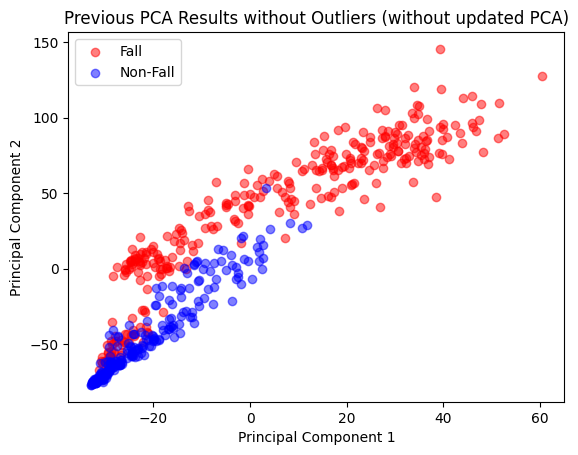

In [17]:
# Remove the first maximum outlier from the first principal component

max_index = np.argmax(principal_components[:, 0])
principal_components_no_outliers = np.delete(principal_components, max_index, axis=0)
labels_no_outlier = np.delete(data_labels, max_index, axis=0)
data_features_no_outlier = np.delete(data_features, max_index, axis=0)

# Remove the first maximum outlier from the second principal component
max_index = np.argmax(principal_components_no_outliers[:, 1])
principal_components_no_outliers = np.delete(
    principal_components_no_outliers, max_index, axis=0
)
labels_no_outlier = np.delete(labels_no_outlier, max_index, axis=0)
data_features_no_outlier = np.delete(data_features_no_outlier, max_index, axis=0)

print(
    "Principal Components without outliers shape: ",
    principal_components_no_outliers.shape,
)
print("Labels without outliers shape: ", labels_no_outlier.shape)
print("Data without outliers shape: ", data_features_no_outlier.shape)

# Plot the previous PCA results without the outliers
# NOTE: The outliers are removed from the data and labels, so we need to calculate the PCA again
# to get the principal components without the outliers, this is just for visualization purposes
plot_pca_results(
    principal_components_no_outliers,
    labels_no_outlier,
    "Previous PCA Results without Outliers (without updated PCA)",
)

Applied PCA again to data without outliers.


Principal Components without outliers shape:  (564, 2)
Explained Variance Ratios without outliers:  [0.40272259 0.18999792]
Eigenvalues without outliers:  [3962.56193172 1869.47175434]
Total Explained Variance Percentage without outliers:  59.27205104560262


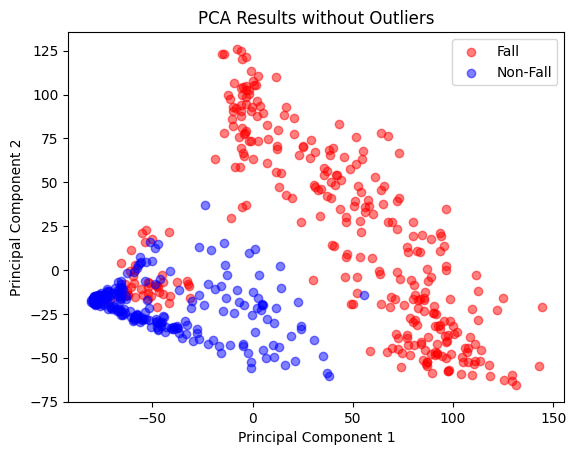

In [18]:
# Applay PCA to data withou outliers
pca_no_outliers = PCA(n_components=2)
principal_components_no_outliers = pca_no_outliers.fit_transform(
    data_features_no_outlier
)
explained_variance_ratios_no_outliers = pca_no_outliers.explained_variance_ratio_
eigenvalues_no_outliers = pca_no_outliers.explained_variance_
total_explained_variance_percentage_no_outliers = (
    sum(explained_variance_ratios_no_outliers) * 100
)

print(
    "Principal Components without outliers shape: ",
    principal_components_no_outliers.shape,
)
print(
    "Explained Variance Ratios without outliers: ",
    explained_variance_ratios_no_outliers,
)
print("Eigenvalues without outliers: ", eigenvalues_no_outliers)
print(
    "Total Explained Variance Percentage without outliers: ",
    total_explained_variance_percentage_no_outliers,
)

plot_pca_results(
    principal_components_no_outliers, labels_no_outlier, "PCA Results without Outliers"
)

Scaled the data with Min-Max scaling to normalize the data and get better results.
Transformed the labels to binary, F=1, NF=0.


In [19]:
# Scale the data with the MinMaxScaler to normalize the data
min_max_scaler = MinMaxScaler()
data_features_scaled = min_max_scaler.fit_transform(data_features_no_outlier)
# Transform the labels to binary, F=1, NF=0 for the binary classification in the future
data_labels_binary = np.where(labels_no_outlier == "F", 1, 0)

Applied PCA again to normalized data.


Principal Components normalized shape:  (564, 2)
Explained Variance Ratios normalized:  [0.2664839  0.22066081]
Eigenvalues normalized:  [2.288873   1.89529111]
Total Explained Variance Percentage normalized:  48.71447026228698


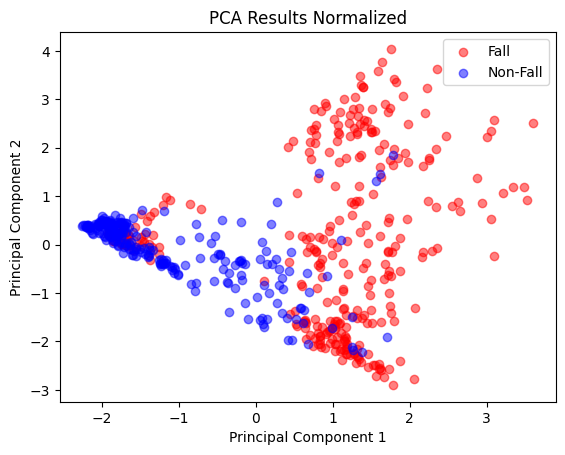

In [20]:
# Apply PCA again to data without outliers
pca_normalized = PCA(n_components=2)
principal_components_normalized = pca_normalized.fit_transform(data_features_scaled)
explained_variance_ratios_normalized = pca_normalized.explained_variance_ratio_
eigenvalues_normalized = pca_normalized.explained_variance_
total_explained_variance_percentage_normalized = (
    sum(explained_variance_ratios_normalized) * 100
)

print("Principal Components normalized shape: ", principal_components_normalized.shape)
print("Explained Variance Ratios normalized: ", explained_variance_ratios_normalized)
print("Eigenvalues normalized: ", eigenvalues_normalized)
print(
    "Total Explained Variance Percentage normalized: ",
    total_explained_variance_percentage_normalized,
)

plot_pca_results(
    principal_components_normalized, labels_no_outlier, "PCA Results Normalized"
)

Applied K-means


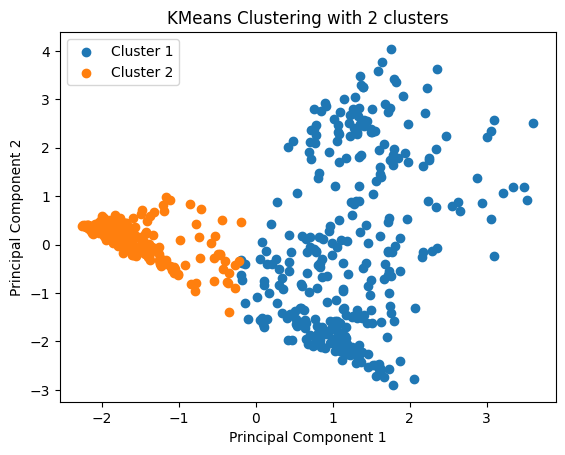

Accuracy of the clustering with  2  clusters:  0.8191489361702128


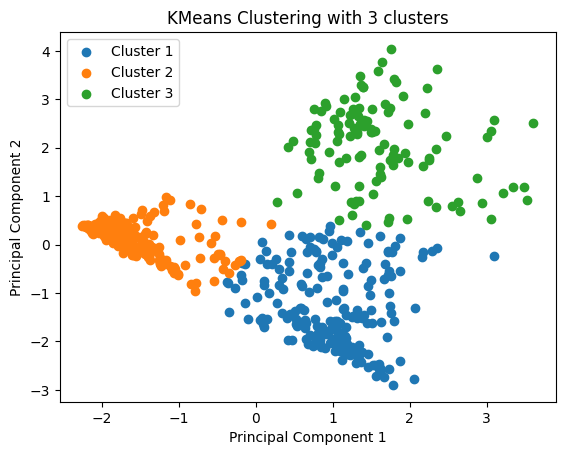

Accuracy of the clustering with  3  clusters:  0.8173758865248227


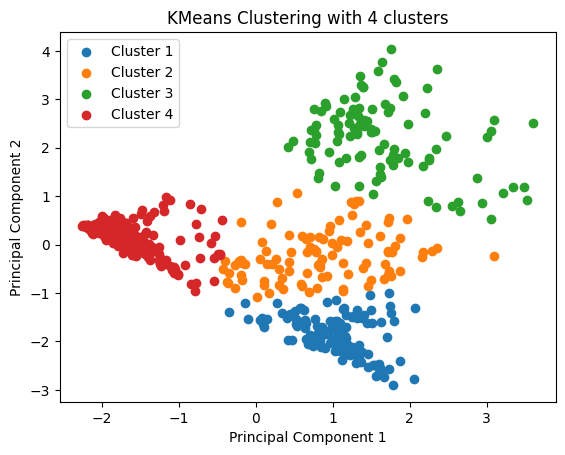

Accuracy of the clustering with  4  clusters:  0.8014184397163121


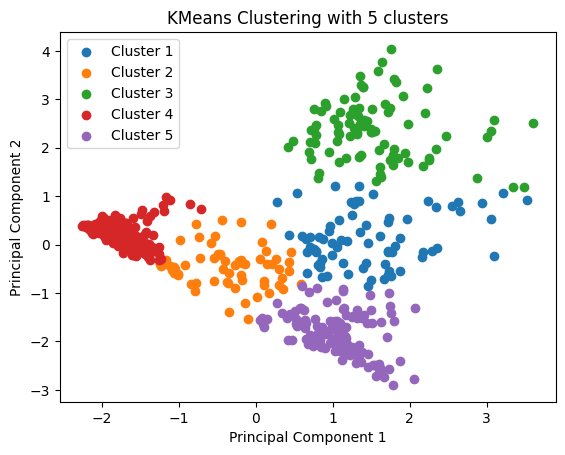

Accuracy of the clustering with  5  clusters:  0.8563829787234043


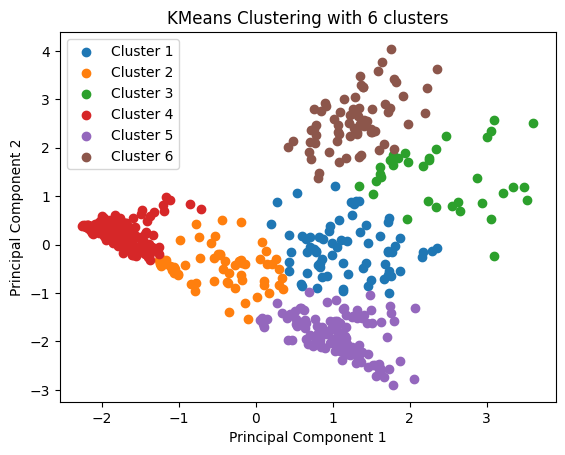

Accuracy of the clustering with  6  clusters:  0.8546099290780141


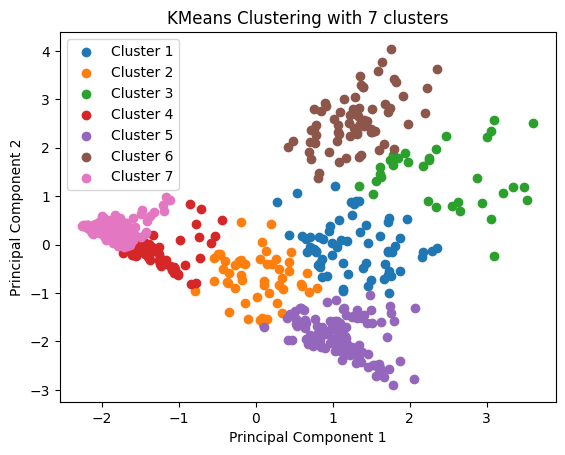

Accuracy of the clustering with  7  clusters:  0.8670212765957447


In [21]:
# Plotting function to plot the KMeans clustering results for different number of clusters
def plot_kmeans_results(principal_components, labels, n_clusters):
    plt.figure()
    for i in range(n_clusters):
        plt.scatter(
            principal_components[labels == i, 0],
            principal_components[labels == i, 1],
            label="Cluster " + str(i + 1),
        )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("KMeans Clustering with " + str(n_clusters) + " clusters")
    plt.legend()
    plt.show()


# Map the cluster labels of the k-means into 1 and 0's according to the majority label of that cluster.
# If a cluster had more Fall than Non Fall, that label of the cluster will be mapped to Fall.
def map_clusters_predicted_values(labels, predictions, cluster_count):
    new_predictions = np.zeros(len(labels))
    for i in range(cluster_count):
        cluster_indices = np.where(predictions == i)
        fall_count = np.sum(labels[cluster_indices] == 1)
        non_fall_count = np.sum(labels[cluster_indices] == 0)
        if fall_count > non_fall_count:
            new_predictions[cluster_indices] = 1

    return new_predictions


# Calculate the accuracy of the clustering results
def calculate_cluster_accuracy(labels, predictions, cluster_count):
    correct_predictions = map_clusters_predicted_values(
        labels, predictions, cluster_count
    )
    return accuracy_score(labels, correct_predictions)


# Inertia values for different number of clusters
inertia_values = []
# Accuracy scores for different number of clusters
accuracy_scores = []

# Apply KMeans clustering to the normalized data withe different number of clusters
for n_clusters in range(2, 16):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    prediction = kmeans.fit_predict(principal_components_normalized)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Calculate the inertia value of the clustering
    inertia_values.append(kmeans.inertia_)

    # Calculate the accuracy of the clustering
    accuracy_scores.append(
        calculate_cluster_accuracy(data_labels_binary, labels, n_clusters)
    )

    # Plot the KMeans clustering results for different number of clusters
    # Also, calculate the accuracy of the clustering results
    if n_clusters <= 7:
        plot_kmeans_results(principal_components_normalized, labels, n_clusters)
        print(
            "Accuracy of the clustering with ",
            n_clusters,
            " clusters: ",
            accuracy_scores[-1],
        )

Inertia of K-means


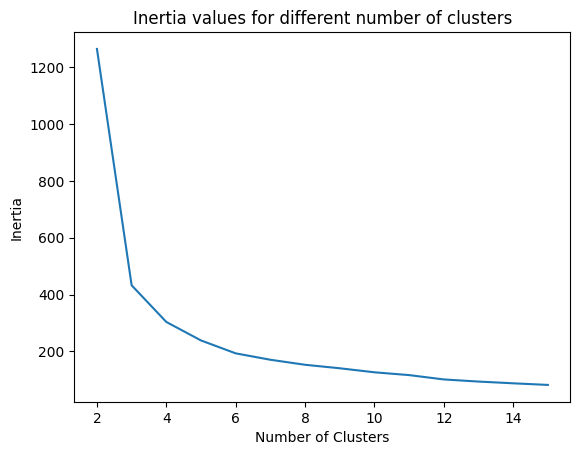

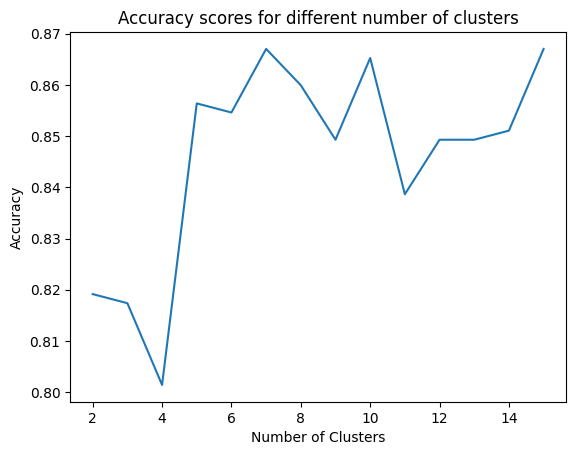

In [22]:
# Plot the inertia values for different number of clusters
plt.figure()
plt.plot(range(2, 16), inertia_values)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Inertia values for different number of clusters")
plt.show()

# Plot the accuracy scores for different number of clusters
plt.figure()
plt.plot(range(2, 16), accuracy_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy")
plt.title("Accuracy scores for different number of clusters")
plt.show()

# Part B

### SVM


In [23]:
# Apply SVM to the normalized data

# First split the normalized data into training, validation and testing sets
# 85% training, 15% testing
# NOTE: Validation set is automatically created by GridSearchCV with cv=6 as 14.1% of the data
data_train, data_test, labels_train, labels_test = train_test_split(
    data_features_scaled, data_labels_binary, test_size=0.15, random_state=random_state
)

# Find the best hyperparameters for the SVM model
# Use GridSearchCV to find the best hyperparameters for the SVM model
# Create two dictionaries for the hyperparameters to search for
# One is for polynomial kernel and the other is for rbf, linear, and sigmoid kernels
param_grid_poly = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "degree": [2, 3, 4, 5],
    "gamma": ["scale", "auto"],
    "kernel": ["poly"],
}

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf", "linear", "sigmoid"],
}

# Search for the best hyperparameters for the polynomial kernel
svm_poly = SVC()
svm_poly_search = GridSearchCV(svm_poly, param_grid_poly, cv=6)
svm_poly_search.fit(data_train, labels_train)
grid_results_poly = svm_poly_search.cv_results_

# Search for the best hyperparameters for the rbf, linear, and sigmoid kernels
svm = SVC()
svm_search = GridSearchCV(svm, param_grid, cv=6)
svm_search.fit(data_train, labels_train)
grid_results = svm_search.cv_results_

# Combine the results of the polynomial kernel and the rbf, linear, and sigmoid kernels
# and sort them by the mean_test_score

# Combine the results
results = []
for i in range(len(grid_results["mean_test_score"])):
    results.append(
        {
            "mean_test_score": grid_results["mean_test_score"][i],
            "params": grid_results["params"][i],
        }
    )

# Sort the results by the mean_test_score
results = sorted(results, key=lambda x: x["mean_test_score"], reverse=True)

# Show the hyperparameters in the dataframe nicely
results_df = pd.DataFrame(results)
print("Results: ", results_df)

Results:      mean_test_score                                               params
0          1.000000          {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
1          1.000000       {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
2          1.000000        {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
3          1.000000         {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
4          1.000000      {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
5          1.000000       {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
6          1.000000        {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
7          1.000000     {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
8          1.000000         {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
9          1.000000      {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}
10         1.000000     {'C': 100, 'gamma': 'auto', 'kernel': 'sigmoid'}
11         0.997917     {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
12         0.997917      {'C': 0.1, 'gamm

Best SVM classifier


Best Hyperparameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy on the test set for SVM:  98.82352941176471 %
Confusion Matrixfor SVM:  [[38  1]
 [ 0 46]]


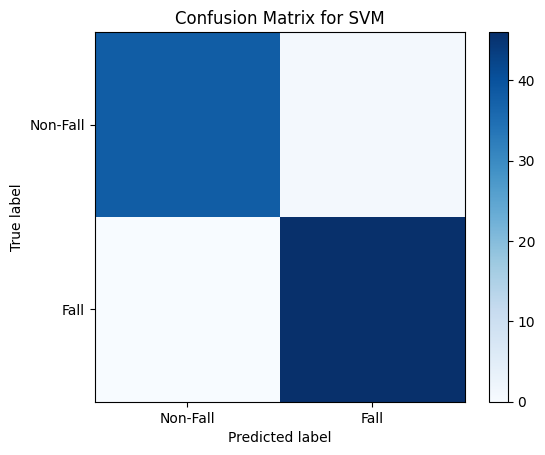

In [24]:
# Get the best hyperparameters
best_hyperparameters = results[0]["params"]
print("Best Hyperparameters: ", best_hyperparameters)

# Train the SVM model with the best hyperparameters
svm_best = SVC(**best_hyperparameters)
svm_best.fit(data_train, labels_train)

# Get the accuracy of the model on the test set in percentage
accuracy_test = svm_best.score(data_test, labels_test)
print("Accuracy on the test set for SVM: ", accuracy_test * 100, "%")

# Get the confusion matrix of the model on the test set
labels_pred = svm_best.predict(data_test)
conf_matrix = confusion_matrix(labels_test, labels_pred)
print("Confusion Matrixfor SVM: ", conf_matrix)

# Plot the confusion matrix
plt.figure()
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Non-Fall", "Fall"])
plt.yticks(tick_marks, ["Non-Fall", "Fall"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

### MLP


In [25]:
# Apply MLP to the normalized data

# Find the best hyperparameters for the MLP model
# Use GridSearchCV to find the best hyperparameters for the MLP model

# Create a dictionary for the hyperparameters to search for
param_grid_mlp = {
    "hidden_layer_sizes": [
        (2),
        (2, 2),
        (4),
        (4, 4),
        (8),
        (8, 8),
        (16),
        (16, 16),
        (32),
        (32, 32),
    ],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ["constant", "invscaling", "adaptive"],
}

# Search for the best hyperparameters for the MLP model
mlp = MLPClassifier()
mlp_search = GridSearchCV(mlp, param_grid_mlp, cv=6, scoring="accuracy", n_jobs=-1)
mlp_search.fit(data_train, labels_train)
grid_results = mlp_search.cv_results_

# Combine the results
results = []
for i in range(len(grid_results["mean_test_score"])):
    results.append(
        {
            "mean_test_score": grid_results["mean_test_score"][i],
            "params": grid_results["params"][i],
        }
    )

# Sort the results by the mean_test_score
results = sorted(results, key=lambda x: x["mean_test_score"], reverse=True)

# Show the hyperparameters in the dataframe nicely
results_df = pd.DataFrame(results)
print("Results: ", results_df)

Results:        mean_test_score  \
0            1.000000   
1            1.000000   
2            1.000000   
3            1.000000   
4            1.000000   
5            1.000000   
6            1.000000   
7            1.000000   
8            1.000000   
9            1.000000   
10           1.000000   
11           1.000000   
12           1.000000   
13           1.000000   
14           1.000000   
15           1.000000   
16           1.000000   
17           1.000000   
18           1.000000   
19           1.000000   
20           1.000000   
21           1.000000   
22           1.000000   
23           1.000000   
24           1.000000   
25           1.000000   
26           1.000000   
27           1.000000   
28           1.000000   
29           1.000000   
30           1.000000   
31           1.000000   
32           1.000000   
33           1.000000   
34           1.000000   
35           1.000000   
36           1.000000   
37           1.000000   
38           1.

Best MLP


Best Hyperparameters for MLP:  {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': 2, 'learning_rate': 'constant', 'solver': 'lbfgs'}
Accuracy on the test set for MLP:  97.6470588235294 %
Confusion Matrix for MLP:  [[37  2]
 [ 0 46]]


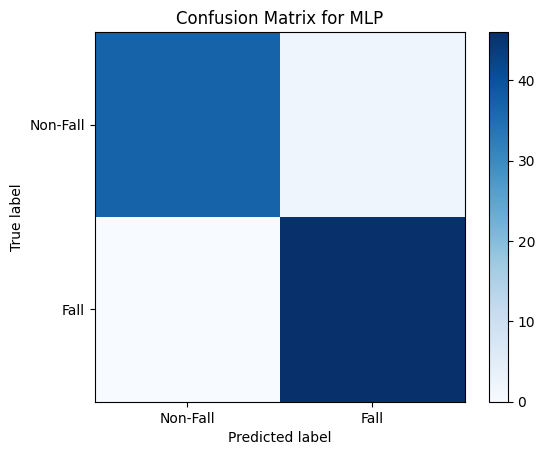

In [26]:
# Get the best hyperparameters
best_hyperparameters_mlp = mlp_search.best_params_
print("Best Hyperparameters for MLP: ", best_hyperparameters_mlp)

# Train the MLP model with the best hyperparameters
mlp_best = MLPClassifier(**best_hyperparameters_mlp)
mlp_best.fit(data_train, labels_train)

# Get the accuracy of the model on the test set in percentage
accuracy_test_mlp = mlp_best.score(data_test, labels_test)
print("Accuracy on the test set for MLP: ", accuracy_test_mlp * 100, "%")

# Get the confusion matrix of the model on the test set
labels_pred_mlp = mlp_best.predict(data_test)
conf_matrix_mlp = confusion_matrix(labels_test, labels_pred_mlp)
print("Confusion Matrix for MLP: ", conf_matrix_mlp)

# Plot the confusion matrix
plt.figure()
plt.imshow(conf_matrix_mlp, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MLP")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Non-Fall", "Fall"])
plt.yticks(tick_marks, ["Non-Fall", "Fall"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()